In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from src.data import pretraining_pipeline
from src.models import get_ASTROMER
from src.utils import get_metrics
import tomli

from sklearn.metrics import r2_score, mean_squared_error

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [80]:
mask_frac = 10
lambda_pe = 1

root = './presentation/experiments/astromer_0/'
# _zero-mean_LR1e-05
path_ckpts = f'{root}/results/macho_new_mask_{mask_frac}_{lambda_pe}_zero-mean_LR1e-05/'
path_conf = f'{root}/config_files/macho_new_mask_{mask_frac}_{lambda_pe}_zero-mean_LR1e-05/alcock.100.f0.a.toml'

with open(path_conf, mode="rb") as fp:
    config = tomli.load(fp)     
path_ckpts

'./presentation/experiments/astromer_0//results/macho_new_mask_10_1_zero-mean_LR1e-05/'

In [81]:
# ft_metrics = pd.read_csv(os.path.join(path_ckpts, 'pretraining', 'metrics.csv'))

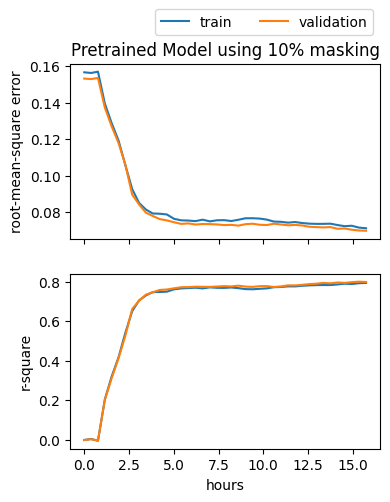

In [82]:
fig, axes = plt.subplots(2, 1, figsize=(4,5), sharex=True)

ft_name_metric = ['rmse', 'r_square']
titles = ['root-mean-square error', 'r-square']
for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    val_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'validation'), 
                           show_keys=False, full_logs=True, metric_name=metric_name)
    
    train_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'train'), 
                                 show_keys=False, full_logs=True, metric_name=metric_name)       
    
    train_logs['wall_time'] = (train_logs['wall_time'] - train_logs['wall_time'].iloc[0])/(60*60)
    val_logs['wall_time'] = (val_logs['wall_time'] - val_logs['wall_time'].iloc[0])/(60*60)
    
    axes[i].plot(train_logs['wall_time'], train_logs['value'], label='train')
    axes[i].plot(val_logs['wall_time'], val_logs['value'], label='validation')
#     test_rmse = ft_metrics[ft_metrics['step'] == 'pretraining'][ft_name_metric[i]].values
    
#     axes[i].axhline(y=test_rmse, color='g', linestyle='--', label='test')
    axes[i].set_ylabel(titles[i])
axes[-1].set_xlabel('hours')
axes[0].set_title(f'Pretrained Model using {mask_frac}% masking')
axes[0].legend(bbox_to_anchor = (1., 1.35), ncol=3)
plt.show()

## Attention 

In [83]:
config['pretraining']['data']['sampling']
config['masking']['mask_frac']

0.1

In [84]:
# LOADING DATA
BATCH_SIZE = 2500
test_batches = pretraining_pipeline(os.path.join(config['pretraining']['data']['path'], 'test'),
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    0., #config['masking']['mask_frac'],
                                    0., #config['masking']['rnd_frac'],
                                    0., #config['masking']['same_frac'],
                                    sampling=False,
                                    shuffle=False,
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])
test_data = test_batches.take(1)

[INFO] Repeating dataset x1 times


In [85]:
os.path.join(config['finetuning']['weights'], 'weights')

'./presentation/experiments/astromer_0/results/macho_new_mask_10_1_zero-mean_LR1e-05/pretraining/weights'

In [86]:
d_model = config['astromer']['head_dim']*config['astromer']['heads']
astromer =  get_ASTROMER(num_layers=config['astromer']['layers'],
                         d_model=d_model,
                         num_heads=config['astromer']['heads'],
                         dff=config['astromer']['dff'],
                         base=config['positional']['base'],
                         dropout=config['astromer']['dropout'],
                         maxlen=config['astromer']['window_size'],
                         pe_c=config['positional']['alpha'],
                         no_train=False)

astromer.load_weights(os.path.join(config['finetuning']['weights'], 'weights')).expect_partial()

PE_C RECEIVED:  tf.Tensor(1.0, shape=(), dtype=float32)


In [87]:
optimizer = tf.optimizers.Adam(1e-3)
astromer.compile(optimizer=optimizer)
astromer.evaluate(test_data)

2/2 [==============================] - 26s 29ms/step - loss: 0.0789 - r_square: 0.7077


[0.07892948389053345, 0.7077020406723022]

In [88]:
x_pred = astromer.predict(test_data)

In [89]:
x_true = tf.concat([y['target'] for _, y in test_data], 0)
x_time = tf.concat([x['times'] for x, _ in test_data], 0)
x_mask = tf.concat([y['mask_out'] for _, y in test_data], 0)

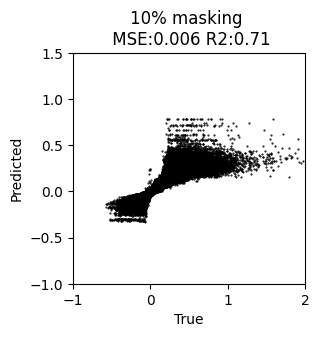

In [90]:
plt.figure(figsize=(3,3), dpi=100)

r2_list,mse_list =[], []
for xp, xt, xm in zip(x_pred, x_true, x_mask):
    xp = tf.boolean_mask(xp, xm)
    xt = tf.boolean_mask(xt, xm)
    
    r2_value = r2_score(xt, xp)
    mse_value = mean_squared_error(xt, xp)
    r2_list.append(r2_value)
    mse_list.append(mse_value)
    plt.scatter(xt, xp, marker='.', s=1, color='k')

plt.title("{}% masking \n MSE:{:.3f} R2:{:.2f}".format(mask_frac, np.mean(mse_list), np.mean(r2_list)))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.ylim(-1, 1.5)
plt.xlim(-1, 2)
plt.show()

In [22]:
import numpy as np
from sklearn.metrics import r2_score

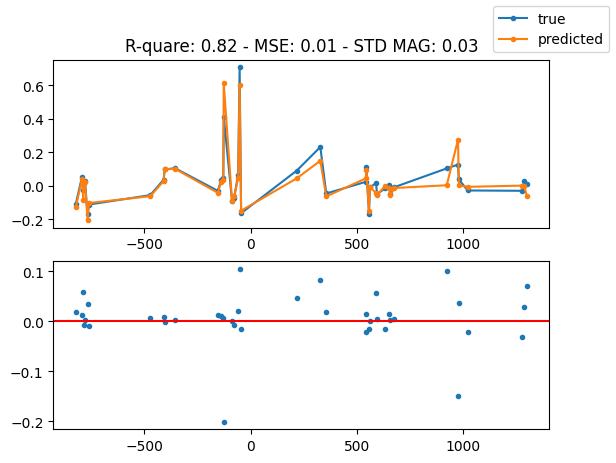

In [27]:
n = np.random.randint(0, len(x_true))

for i in range(n, n+1):
    fig, axes = plt.subplots(2, 1)
    curr_m = x_mask[i]
    curr_x = x_true[i]
    curr_y = x_pred[i]
    curr_t = x_time[i]
    
    curr_x_masked = tf.boolean_mask(curr_x, curr_m)
    curr_y_masked = tf.boolean_mask(curr_y, curr_m)
    curr_t_masked = tf.boolean_mask(curr_t, curr_m)
    
    residuals = curr_x_masked-curr_y_masked
    
    mse = np.mean(residuals)
    std_mag = np.mean(curr_x_masked)
    r2 = r2_score(curr_x, curr_y)
    
    axes[0].set_title('R-quare: {:.2f} - MSE: {:.2f} - STD MAG: {:.2f}'.format(r2, mse, std_mag))
    axes[0].plot(curr_t_masked, curr_x_masked, marker='.', label='true')
    axes[0].plot(curr_t_masked, curr_y_masked, marker='.', label='predicted')
    axes[1].plot(curr_t_masked, residuals, marker='.', linestyle='')
    axes[1].axhline(y=0., color='r', linestyle='-')
    

    fig.legend()

## Attention weights

In [28]:
# LOADING DATA
BATCH_SIZE = 512
print(config['finetuning']['data']['path'])
test_batches = pretraining_pipeline('./data/records/ogle/fold_0/ogle_500/test/',
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    0.,
                                    0.,
                                    0.,
                                    False,
                                    False,
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])
test_data = test_batches.take(1)

./data/records/alcock/fold_0/alcock_100
[INFO] Repeating dataset x1 times


In [29]:
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
output_notebook()
    
def att_interactive_plot(x, y, att, title='light curve'):
    best_indices = np.argmax(att, 1)
    best_z = [z[best_indices[i]] for i, z in enumerate(att)]
    # Create a ColumnDataSource with our data
    source = ColumnDataSource(data=dict(x=x, y=y, values=best_indices, att_val=best_z, size=[10]*len(x)))

    # Create the plot
    p = figure(title=title, width=1000, height=250)
    p.line('x', 'y', source=source, line_width=2)
    c = p.circle('x', 'y', source=source, size='size', line_color=None, fill_alpha=0.5)

    hover_callback = CustomJS(args={'source': c}, code = """
        const indices = cb_data.index.indices
        
        console.log(source.value)
        """ )
    
    # Create a HoverTool to display the corresponding value when hovering over a data point
    hover = HoverTool(tooltips=[('Value', '@values'), ('Z', '@att_val')], 
                      mode='vline', callback=hover_callback)
    p.add_tools(hover)

    # Set the x-axis tick locations and labels
    p.xaxis.ticker = x[..., 0]
    p.xaxis.major_label_overrides = {float(tick): str(label) for tick, label in zip(x[...,0], np.arange(len(x)))}

    # Show the plot
    show(p)

Loading BokehJS ...

/tmp/ipykernel_46559/4064982482.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 199 + 1) instead
  indices_selected = np.random.random_integers(0, len(curr_x)-1, 200)
/tmp/ipykernel_46559/4064982482.py:20: RuntimeWarning: divide by zero encountered in log
  axes[1].imshow(np.log(curr_w[0]))


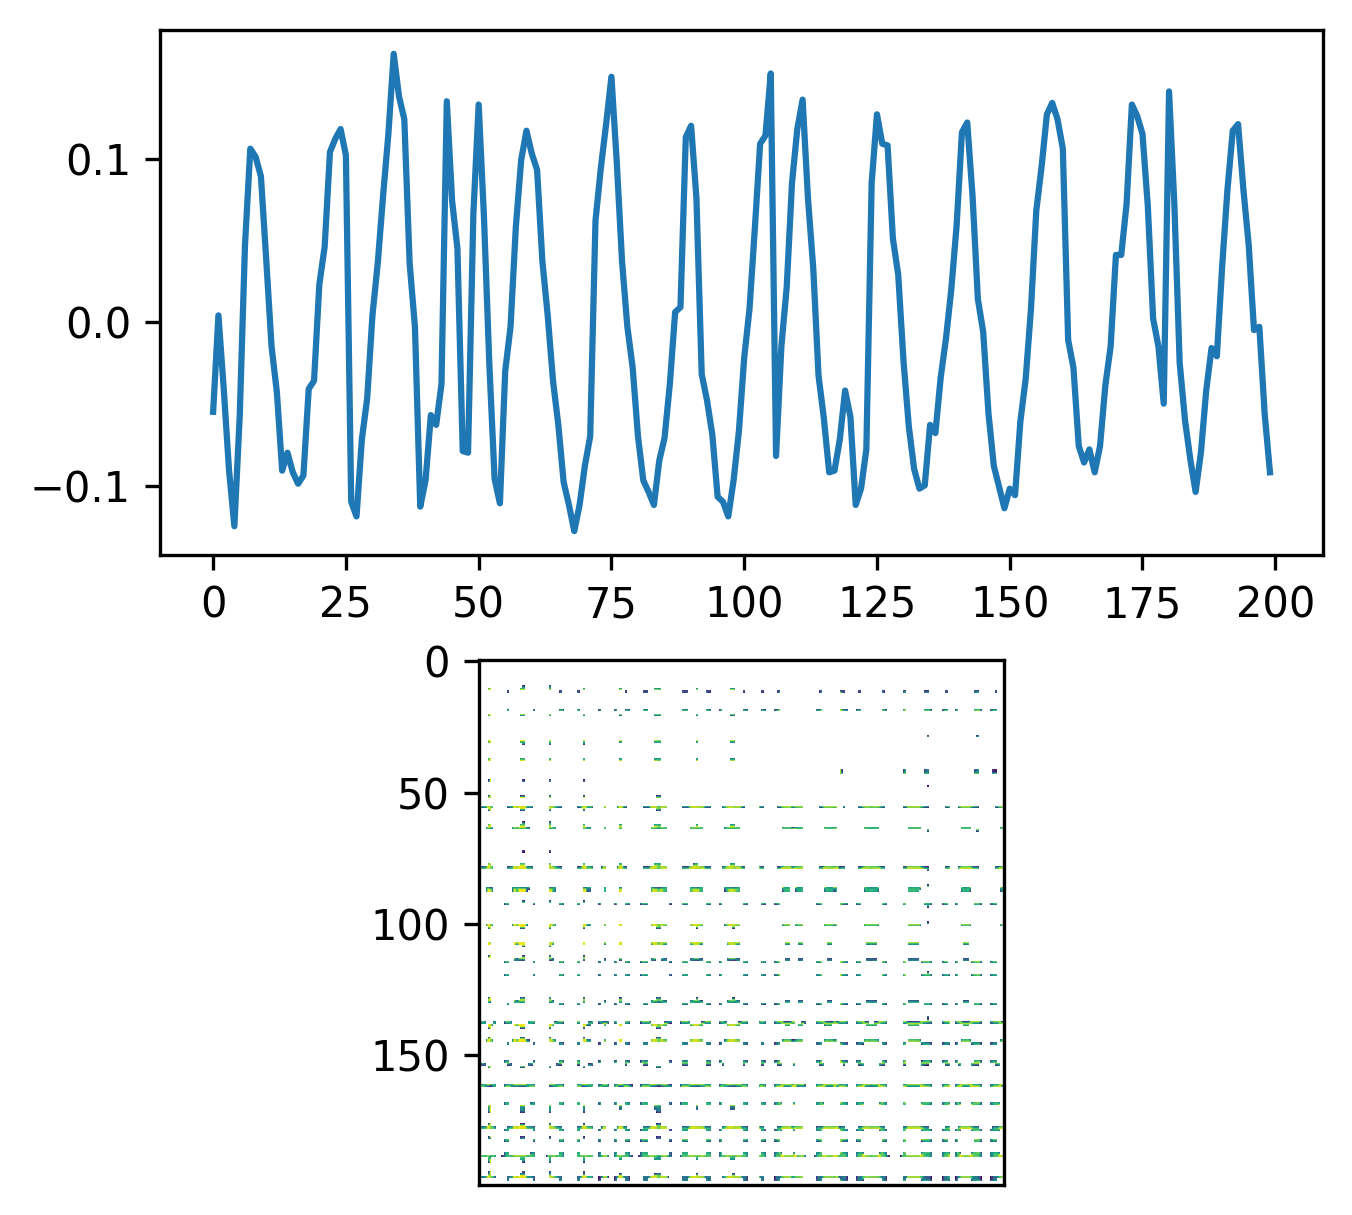

In [30]:
encoder = astromer.get_layer('encoder')

for x, y in test_data:
    output, weights = encoder(x, return_weights=True)    
#     index = np.random.randint(0, output.shape[0])
    index = 10
    curr_w = np.array(weights[index])
    curr_x = np.array(x['input'][index])
    curr_t = np.array(x['times'][index])
        
    indices_selected = np.random.random_integers(0, len(curr_x)-1, 200)
    indices_selected = np.sort(indices_selected)
    
    fig, axes = plt.subplots(2, 1, sharex=False, dpi=300, figsize=(5,5))
    axes[0].plot(curr_x)
#     att_interactive_plot(curr_t[indices_selected], 
#                          curr_x[indices_selected], 
#                          att=curr_w[0][indices_selected])
    
    axes[1].imshow(np.log(curr_w[0]))
    axes[1].set_xticks([])

#     plt.colorbar()
    plt.show()

In [144]:
path_ckpts

'./presentation/experiments/astromer_0/results/macho_new_mask_20_1_zero-mean_LR1e-05/'

## Classification

In [145]:
import numpy as np 

to_change = {'a':'b', 'b':'a'}

clf_metrics = pd.read_csv(os.path.join(path_ckpts, 'alcock', 'classification','metrics.csv'))
# # clf_metrics[clf_metrics['sci_case'] == 'a'].sample()
# clf_metrics['sci_case'] = clf_metrics['sci_case'].apply(lambda x: to_change[x])

FileNotFoundError: [Errno 2] No such file or directory: './presentation/experiments/astromer_0/results/macho_new_mask_20_1_zero-mean_LR1e-05/alcock/classification/metrics.csv'

In [109]:
styles = {'mlp_att':{'marker':'^', 'linestyle':'-', 'name':'MLP+ATT'}, 
          'lstm_att':{'marker':'o', 'linestyle':'--', 'name':'LSTM+ATT'}, 
          'lstm':{'marker':'s', 'linestyle':':', 'name':'Baseline'},
          'mlp_att_conv':{'marker':'.', 'linestyle':'--', 'name':'MLP+ATT+CONV'},
          'mlp_first':{'marker':'*', 'linestyle':':', 'name':'MLP+FIRST'},
          'mlp_last':{'marker':'v', 'linestyle':'-', 'name':'MLP+LAST'},
         }

ft_names_changed = {
    'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'
}

FileNotFoundError: [Errno 2] No such file or directory: './presentation/experiments/astromer_0/results/macho_new_mask_20_1_zero-mean_LR1e-05/alcock/classification/metrics.csv'

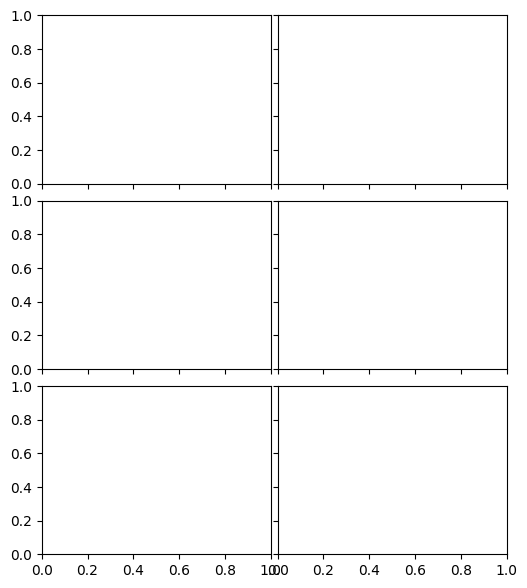

In [110]:
### marker_models = ['s', '^', 'o', 'v']

fig, axes = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(6,7), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03})
    
for row, target in enumerate(['alcock', 'ogle', 'atlas']):
    clf_metrics = pd.read_csv(os.path.join(path_ckpts, target, 'classification','metrics.csv'))
    
    clf_metrics['sci_case'] = clf_metrics['sci_case'].apply(lambda x: to_change[x])

    best_baseline = []
    for col, sci_case in enumerate(['a']):
        
        if row == 0:
            axes[row][col].set_title(sci_case)
            
        for model_index, clf_model in enumerate(['lstm', 'mlp_att','lstm_att']):
            partial = clf_metrics[(clf_metrics['target'] == target) & \
                                  (clf_metrics['sci_case'] == sci_case) & \
                                  (clf_metrics['model'] == clf_model)]

            spc_cases, scores_mean, scores_std = [], [], []
            for spc, frame in partial.groupby('spc'):
                spc_cases.append(spc)
                scores_mean.append(frame['test_f1'].mean())
                scores_std.append(frame['test_f1'].std())
            
            x_whole = [20, 50, 100, 500]
            x_range = np.array([x_whole.index(c) for c in spc_cases])

            axes[row][col].errorbar(x_range, scores_mean, 
                               marker=styles[clf_model]['marker'], 
                               label=styles[clf_model]['name'],
                               linestyle=styles[clf_model]['linestyle'],
                               color='k')
            axes[row][col].fill_between(x_range, 
                                       np.array(scores_mean)+np.array(scores_std), 
                                       np.array(scores_mean)-np.array(scores_std),
                                       color='k', alpha=0.1)
            
            axes[row][col].set_xticks(x_range)
            axes[row][col].set_xticklabels([int(x) for x in spc_cases])
            axes[row][col].set_yticks([round(x, 1) for x in np.linspace(0.1, 0.8, 10)])

            
            if clf_model == 'lstm':
                print(scores_mean)
                best_baseline.append(np.max(scores_mean))
    
        axes[row][col].axhline(y=np.max(best_baseline), 
                               color='red', 
                               linestyle='--', 
                               linewidth=1, 
                               label='Best Baseline')
    
        if col == 1:
            ax2 = axes[row][col].twinx()     
            ax2.set_yticks([])
            ax2.set_ylabel(ft_names_changed[target])

        

axes[1][0].set_ylabel('F1 Score')
axes[0][0].legend(ncol=2, bbox_to_anchor = (1.7, 1.6), fontsize=12)
fig.text(0.51, 0.05, 'Samples per class', ha='center', va='center', fontsize=12)